## Studing the $M_{desc}$-vs-$M_{tomp}$ relation :

In [8]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import importlib
plt.style.use('./Notebook.mystyle')

Write the random lmap and peaks to get the descendants for. \
**Note:** If you have downloaded the `LyTomo_data/watersheds*`, you can skip the next cell

In [2]:
def write_random_fields():    
    from codes import minima
    for n in range(1,21):
        lmap_mock = h5py.File('../LyTomo_data/watersheds_z'+str(z)+'/mocks/n'+str(n)
                              +'/labeled_map_TNG_z'+str(z)+'_n'+str(n)
                              +'_sigma4_th'+str(np.around(th,2)).ljust(4,'0')
                              +'_lc'+str(np.around(lc,2)).ljust(4,'0')+'.hdf5','r')['map'][:]
        peaks_mock = h5py.File('../LyTomo_data/watersheds_z'+str(z)+'/mocks/n'
                               +str(n)+'/peaks_TNG_z'+str(z)+'_n'+str(n)
                               +'_sigma4_th'+str(np.around(th,2)).ljust(4,'0')
                               +'_lc'+str(np.around(lc,2)).ljust(4,'0')+'.hdf5', 'r')
        minima.displace_randomly(lmap_mock, peaks, save_lmap='../LyTomo_data/watersheds_z'
                                 +str(z)+'/mocks/n'+str(n)+'/labeled_map_TNG_z2.4_n'+str(n)
                                 +'_sigma4_th2.35_lc2.00_rnd.hdf5', 
                                 save_peaks='../LyTomo_data/watersheds_z'+str(z)+'/mocks/n'
                                 +str(n)+'/peaks_TNG_z2.4_n'+str(n)
                                 +'_sigma4_th2.35_lc2.00_rnd.hdf5',seed=125)

Now refer to the [cook book](https://github.com/mahdiqezlou/LyTomo-Watershed/blob/main/CookBook.ipynb), the section "connection to z=0" to find the descendants of these random fields. 

These are some plotting helper functions:

In [183]:
def get_ind_non_overlapping(lmap1, lmap2):
    """Returns the indices in the lmap1 which overlap with no satershed in lmap2"""
    ind = np.where(lmap2!=0)
    id_overlapping = np.unique(lmap1[ind])[1:]
    id_non_overlapping = np.unique(lmap1)[1:][np.isin(np.unique(lmap1)[1:],
                                                      id_overlapping, invert=True)]
    
    return id_overlapping.astype(int) - 1, id_non_overlapping.astype(int) - 1

def read_files(n, z, sigma, th, lc, conversion_not_adjusted=False, noiseless=False, random=False):
    if conversion_not_adjusted:
        fname = ('../LyTomo_data/descendants/z'+str(z)+'_sigma'+sigma+'_th'+th
                 +'_lc'+str(lc)+'/Mass_voted_FOF_halos_z'+str(z)+'_n'+str(n)
                 +'_sigma'+sigma+'_th'+th+'_halos_lc'+lc+'_conversion_not_adjusted.hdf5')
        pname = ('../LyTomo_data/watersheds_z'+str(z)+'/mocks/n'+str(n)+'/peaks_TNG_z'
                 +str(z)+'_n'+str(n)+'_sigma'+sigma+'_th'+th+'_lc'+lc+'_conversion_not_adjusted.hdf5')
    elif (noiseless):
        fname = ('../LyTomo_data/descendants/z'+str(z)+'_sigma'+sigma+'_th'+th
                 +'_lc'+str(lc)+'/Mass_voted_FOF_halos_true_z'+str(z)+'_n'+str(n)
                 +'_sigma'+sigma+'_th'+th+'_halos_lc'+lc+'.hdf5')
        pname = ('../LyTomo_data/watersheds_z'+str(z)+'/noiseless/peaks_TNG_true_z'
                 +str(z)+'_n'+str(n)+'_sigma'+sigma+'_th'+th+'_lc'+lc+'.hdf5')
    elif(random):
        fname = ('../LyTomo_data/descendants/z'+str(z)+'_sigma'+sigma+'_th'+th
                 +'_lc'+str(lc)+'/Mass_voted_FOF_halos_z'+str(z)+'_n'+str(n)
                 +'_sigma'+sigma+'_th'+th+'_halos_lc'+lc+'_rnd.hdf5')
        pname = ('../LyTomo_data/watersheds_z'+str(z)+'/mocks/n'+str(n)+'/peaks_TNG_z'
                 +str(z)+'_n'+str(n)+'_sigma'+sigma+'_th'+th+'_lc'+lc+'_rnd.hdf5')
    else:
        fname = ('../LyTomo_data/descendants/z'+str(z)+'_sigma'+sigma+'_th'+th
                 +'_lc'+str(lc)+'/Mass_voted_FOF_halos_z'+str(z)+'_n'+str(n)
                 +'_sigma'+sigma+'_th'+th+'_halos_lc'+lc+'.hdf5')
        pname = ('../LyTomo_data/watersheds_z'+str(z)+'/mocks/n'+str(n)+'/peaks_TNG_z'
                 +str(z)+'_n'+str(n)+'_sigma'+sigma+'_th'+th+'_lc'+lc+'.hdf5')

    f = h5py.File(fname,'r')
    peaks = h5py.File(pname,'r')
    
    return f, peaks
    

def get_Mtomo_GroupMass(n, z, sigma='4', th='2.35', lc='2.00', offset=0.114,
                        conversion_not_adjusted=False, noiseless=False, random=False):
    
    f, peaks = read_files(n=n, z=z, sigma=sigma, th=th, lc=lc, 
                          conversion_not_adjusted=conversion_not_adjusted,
                          noiseless=noiseless, random=random)
    GroupMass = 10+np.log10(f['GroupMass'][:])
    ind = f['peak_id'][:].astype(int)-1
    Mtomo = peaks['mtomo'][:][ind] + offset
    if noiseless:
        signif = 0
    else :
        signif = peaks['signif'][ind]
          
    return Mtomo, GroupMass, signif


def get_the_mean_fit(z, sigma, th, lc, conversion_not_adjusted=False, 
                     offset=0.114,nrange=np.arange(1,17,1), random=False):
    
    from scipy.stats import linregress
    slopes, intercepts, M1test, M2test = [], [], [], []
    
    for n in nrange:
        M1, M2, _ = get_Mtomo_GroupMass(n=n, z=z, sigma=sigma, th=th, lc=lc,offset=offset,
                                        conversion_not_adjusted=conversion_not_adjusted
                                        , random=random, noiseless=False)
        co = linregress(M1 - 14, M2) 
        slopes.append(co[0])
        intercepts.append(co[1])
        
    slope_mean, intercept_mean = np.mean(slopes), np.mean(intercepts)
    
    print('Slope : ', str(slope_mean)[:5]+'+-'+str(np.std(slopes))[:5])
    print('The prefactor : ', str(intercept_mean)[:5]+'+-'+str(np.std(intercepts))[:5])

    return (slope_mean, intercept_mean)

def _get_err(co, M1, M2, bins=np.array([13, 13.75, 14.25, 14.75, 15.5])):
    
    fit = lambda x : co[0]*(x-14) +co[1]
    err = []
    for i in range(bins.size-1):
        ind = np.where( (M1 > bins[i])*(M1 < bins[i+1]))
        dev = fit(M1[ind]) - M2[ind]
        err.append(np.sqrt(np.sum(dev*dev)/dev.size))
    return np.array(err)


def test_fit(co, conversion_not_adjusted, z, sigma, th, lc, offset=0.114, ntest=np.arange(17,21),
             bins= np.array([13, 14, 14.25, 14.75, 15.5]), random=False):
    """Find the errors for in mass bins of bins for the mock maps array of ntest"""
    
    errall = np.zeros(shape=(ntest.size, bins.size-1))
    for i, n in enumerate(ntest):
        M1, M2, _ = get_Mtomo_GroupMass(n, z=z, sigma=sigma, th=th, 
                                        lc=lc, offset=offset, 
                                        conversion_not_adjusted=conversion_not_adjusted,
                                        random=random)
        errall[i,:] = _get_err(co, M1, M2, bins)
   
    return bins, errall

def get_kde(M1, M2, minmax=(13,16,10,16), ngridsx=80):

    from scipy.stats import gaussian_kde as gkde
    
    data = np.zeros((2,M1.size))
    data[0,:] = M1
    data[1,:] = M2

    kernel = gkde(data)
    if ngridsx == 80:
        X, Y = np.mgrid[minmax[0]:minmax[1]:80j, minmax[2]:minmax[3]:160j]
    else:
        X, Y = np.mgrid[minmax[0]:minmax[1]:95j, minmax[2]:minmax[3]:160j]
    grid_points = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(kernel(grid_points).T, X.shape)
    del X, Y
    
    return Z


def get_mean_KDE(conversion_not_adjusted, offset=0.114,  z=2.4, sigma='4', th='2.35', lc='2.00', nmocks=20):
    
    Zall = []
    if sigma == '4':
        minmax=(13.0,16,10,16)
        ngridsx = 80
    else : 
        minmax=(12.5,16,10,16)
        ngridsx= 95
        
    for n in np.arange(1,nmocks+1):
        Mtomo, GroupMass, _ = get_Mtomo_GroupMass(n=n, z=z, sigma=sigma, th=th, lc=lc, offset=offset, 
                                                  conversion_not_adjusted=conversion_not_adjusted)
        Zall.append(get_kde(Mtomo, GroupMass, minmax, ngridsx))

    

    Zmean = np.zeros(shape=(ngridsx,160))
    for Z in Zall:
        Zmean += Z
    Zmean /= nmocks
    
    return Zmean
        

In [195]:
def scatter_hist(n, fig, ax, ax_histx, ax_histy, ax_err, ax_err_label, offset, 
                 conversion_not_adjusted, z=2.4, sigma='4', th='2.35', lc='2.00',
                 bin_size=0.4, plot_kde=False, plot_noiseless=True, 
                 bins_err=np.array([13.3,14.0,14.5,15.0,15.5])):
    import matplotlib
    
    Mtomo, GroupMass, signif = get_Mtomo_GroupMass(n=n, z=z, sigma=sigma, th=th, lc=lc, offset=offset,
                                                   conversion_not_adjusted=conversion_not_adjusted)
    Mtomo_noiseless, GroupMass_noiseless, _ = get_Mtomo_GroupMass(n=n, z=z, th=th, lc=lc, sigma=sigma,
                                                                  offset=offset, noiseless=True,
                                                                  conversion_not_adjusted=False)
    print('Number of watersheds = ', Mtomo.size)
    if sigma=='2' :
        vmax=0.6
        edgecolor='w'
        extent = [12.5, 16, 10, 16]
        lmap4 = h5py.File('../LyTomo_data/watersheds_z2.4/mocks/n'+str(n)
                          +'/labeled_map_TNG_z2.4_n'+str(n)+'_sigma4_th2.35'
                          +'_lc2.00.hdf5','r')['map'][:]
        lmap2 = h5py.File('../LyTomo_data/watersheds_z2.4/mocks/n'+str(n)
                          +'/labeled_map_TNG_z2.4_n'+str(n)+'_sigma2_th2.75'
                          +'_lc2.30.hdf5','r')['map'][:]
        ind_overlapping, ind_non_overlapping = get_ind_non_overlapping(lmap2, lmap4)
        err_yticks = np.arange(0.3,1.0,0.1)
        ax_err.set_xlim(12.5, 15.5)
        ax_histx.set_yticks(ticks = np.arange(10,215, 50))
        ax_histy.set_xticks(ticks = np.arange(10,215, 50))
        ax.set_xlim(12.5,15.5)        
    else:
        vmax=0.8
        edgecolor='w'
        print('Number of watersheds = ', Mtomo.size)
        ind_overlapping = np.ones_like(Mtomo, dtype=bool)
        ind_non_overlapping = np.zeros_like(Mtomo, dtype=bool)
        extent = [13.0, 16, 10, 16]
        err_yticks = np.arange(0.3,0.65,0.05)
        ax_err.set_xlim(13.0, 15.5)
        ax_histy.set_xticks(ticks = np.arange(10,75, 20))
        ax_histx.set_yticks(ticks= np.arange(10,100,20))
        ax.set_xlim(13.0,15.5)
    ax.set_ylim(10.5,15.5)
    
    if plot_kde :
        legendcolor='w'
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        Zmean = get_mean_KDE(conversion_not_adjusted=conversion_not_adjusted,
                             offset=offset, z=z, sigma=sigma, th=th, lc=lc)
        im = ax.imshow(np.rot90(Zmean), cmap=plt.cm.viridis, extent = extent,
                       aspect='auto', vmin=0, vmax=vmax)
        if sigma=='2' :
            axins = inset_axes(ax,width="100%", height="100%", 
                               bbox_to_anchor=(0.98,0.3, 0.02, 0.6),
                               bbox_transform=ax.transAxes)
            cb_ticks_pos = 'left'
        else:
            axins = inset_axes(ax,width="100%", height="100%",
                               bbox_to_anchor=(0.05,0.05, 0.02, 0.6),
                               bbox_transform=ax.transAxes)
            cb_ticks_pos = 'right'
        cb = fig.colorbar(im, cax=axins, orientation='vertical',
                          ticks=np.arange(0,vmax+vmax+0.1,0.2))
        cb.ax.yaxis.set_tick_params(color='k')
        cb.ax.yaxis.set_ticks_position(cb_ticks_pos)
        cb.ax.yaxis.set_label_position(cb_ticks_pos)
        plt.setp(plt.getp(axins, 'yticklabels'), color=legendcolor)
        cb.ax.set_ylabel('Gaussian KDE', labelpad=5, color=legendcolor, fontsize=20)

    ind1 = (signif[ind_overlapping] > -2.5)*(signif[ind_overlapping] < -2.0)
    ind2 = (signif[ind_overlapping] > -3.0)*(signif[ind_overlapping] < -2.5)
    ind3 = (signif[ind_overlapping] > -3.5)*(signif[ind_overlapping] < -3.0)
    ind4 = (signif[ind_overlapping] < -3.5)

    with plt.rc_context({'scatter.marker':'o', 'patch.facecolor':'None',
                         'lines.markersize':'5','font.family':'serif'}) :
        if sigma=='4':
            ax.scatter(Mtomo[ind_overlapping][ind1], GroupMass[ind_overlapping][ind1],
                       label=r'$-2.5 < \rm \delta_F / \sigma_{map} < -2.35$',
                       edgecolors='r', facecolor='None', alpha=0.65 ,marker='D',
                       lw=3, s=50)
            ax.scatter(Mtomo[ind_overlapping][ind2], GroupMass[ind_overlapping][ind2],
                       label=r'$-3.0 < \rm \delta_F / \sigma_{map} < -2.5$',
                       edgecolors='C1', facecolor='None', alpha=0.65, marker='s',
                       lw=3, s=50)
        else:
            ax.scatter(Mtomo[ind_non_overlapping], GroupMass[ind_non_overlapping],
                       label='New watersheds',edgecolors='C1', facecolor='none',
                       alpha=0.8, marker='*', lw=3, s=50)
        ax.scatter(Mtomo[ind_overlapping][ind3], GroupMass[ind_overlapping][ind3],
                   label=r'$-3.5 < \rm \delta_F / \sigma_{map} < -3.0$',edgecolors='b',
                   facecolor='None', alpha=0.65, marker='o', lw=3, s=50)
        ax.scatter(Mtomo[ind_overlapping][ind4], GroupMass[ind_overlapping][ind4],
                   label=r'$ \ \rm \delta_F / \sigma_{map} < -3.5$',edgecolors=edgecolor,
                   facecolor='none', alpha=0.6, marker='D', lw=3, s=50)
        
        ax.plot(np.arange(13,16.5),np.arange(13,16.5), label='1:1', color='r', alpha=0.6, ls='--')

        
        ax.set_yticks(ticks= np.arange(11,15.5,0.5))
        ax.set_xticks(ticks=[])
        ax.set_ylabel('log'+r'$ \rm \left(\  M_{desc} (h^{-1} M_{\odot})\right) $', fontsize=30)


        plt.setp(ax.get_xticklabels(), fontsize=20)
        plt.setp(ax.get_yticklabels(), fontsize=20, rotation=20)
        ax.tick_params(axis="x", labelbottom=False)
        ax.grid(True, alpha=0.7)
        ax_histx.tick_params(axis="x", labelbottom=False)
        ax_histy.tick_params(axis="y", labelleft=False)
        ax_histx.set_ylabel('count')
        ax_histy.set_xlabel('count')

        co = get_the_mean_fit(z=z, th=th, lc=lc, offset=offset, sigma=sigma,
                              conversion_not_adjusted=conversion_not_adjusted)
        
        #co_rand = get_the_mean_fit(random=True)
        #Mfit_rand = co_rand[0]*x + co_rand[1]
        #ax.plot(x, Mfit_rand, label='random')
        
        bins = np.arange(np.min(Mtomo), np.max(Mtomo)+2*bin_size,bin_size)
        ax_histx.hist(Mtomo, bins=bins, histtype='step', color='C0')
        plt.setp(ax_histx.get_yticklabels(), fontsize=20)
        
        bins = np.arange(np.min(GroupMass), np.max(GroupMass)+2*bin_size,bin_size)
        ax_histy.hist(GroupMass, bins=bins, histtype='step', 
                      label='Detected \n Watersheds', color='C0', orientation='horizontal')
        
        if (sigma =='4')*(z==2.4):
            M1, M2, _ = get_Mtomo_GroupMass(n=1, z=z, sigma=sigma, random=True)
            bins = np.arange(np.min(M2), np.max(M2)+2*bin_size,bin_size)
            ax_histy.hist(M2, bins=bins, histtype='step', label='random \n watersheds',
                          color='C1', orientation='horizontal', ls='--')
        else :
            bins = np.arange(np.min(GroupMass), np.max(GroupMass)+2*bin_size,bin_size)
            ax_histy.hist(GroupMass[ind_non_overlapping], bins=bins, histtype='step',
                          label="Detected \n only in \n this map", color='C1', 
                          orientation='horizontal', ls='--')
         
        plt.setp(ax_histy.get_xticklabels(), fontsize=20)
        if sigma=='4':
            ax_histy.set_xticks(ticks = np.arange(10,75, 20))
        if sigma=='2':
            ax_histy.set_xticks(ticks = np.arange(10,115, 50))
        ax_histx.grid(True, alpha=0.7)
        ax_histy.grid(True, alpha=0.7)
        ax_histy.legend(loc=(0,0.01), fontsize=17, frameon=False)
        def _plot_uncertainty_M0_paper(ax_err):                    
            with plt.rc_context({'scatter.marker':'o', 'patch.facecolor':'k',
                                 'lines.markersize':'7', 'font.family':'serif'}) :
                
                #bins = np.arange(np.min(Mtomo),np.max(Mtomo)+bin_size+0.05,bin_size)
                #bins = np.delete(bins, -2)
                mbin = np.array([(bins_err[b]+bins_err[b+1])/2 for b in range(0, bins_err.size-1)])
                _ , err = test_fit(co=co, conversion_not_adjusted=conversion_not_adjusted, z=z, 
                                   th=th, lc=lc, offset=offset, bins=bins_err, sigma=sigma)
                ax_err.errorbar(x=mbin, y=np.mean(err, axis=0), yerr=np.std(err, axis=0),
                                marker='o', label=ax_err_label,  markersize=10)
                
                Mfit = co[0]*(mbin-14) + co[1]

                ax.plot(mbin, Mfit, label='power-law estimator', color='k', alpha=0.5)
                
                from scipy.stats import linregress
                if plot_noiseless:
                    co_noiseless = linregress(Mtomo_noiseless-14, GroupMass_noiseless)
                    bins_noiseless = np.arange(np.min(Mtomo_noiseless),
                                               np.max(Mtomo_noiseless)+bin_size,bin_size)
                    bins_noiseless = np.delete(bins_noiseless, -2)
                    mbin_noiseless = np.array([(bins_noiseless[b]+
                                                bins_noiseless[b+1])/2 for b in
                                               range(0, bins_noiseless.size-1)])

                    err_true = _get_err(co_noiseless, Mtomo_noiseless,
                                        GroupMass_noiseless, bins_noiseless)
                    ax_err.plot(mbin_noiseless, err_true, marker='s', ls='--',
                                label='Noiseless', color='C2')
                
                #ax_err.legend(framealpha=0, loc=(0.02,0.15))
                ax_err.legend(framealpha=0, loc='upper right')

                ax_err.set_xlabel('log'+ r'$\ \rm \left( M_{tomo} (h^{-1} M_{\odot})\right) $',
                                  fontsize=30)
                ax_err.set_ylabel('error on '+r'$\rm M_{desc}$'+'(dex)',
                                  fontsize=25)
                
                ax.legend(fontsize=20, loc='lower right', framealpha=0, labelcolor=legendcolor)

                
                ax_err.set_yticks(ticks= err_yticks)
                ax_err.set_xticks(ticks= np.arange(13.0,15.5,0.5))
                if sigma=='4':
                    ax_err.set_ylim((0.20,0.65))
                    
                plt.setp(ax_err.get_xticklabels(), rotation=20, fontsize=20)
                plt.setp(ax_err.get_yticklabels(), rotation=20, fontsize=20)
                ax_err.grid(True, alpha=0.7)


        _plot_uncertainty_M0_paper(ax_err)


## z=2.4 and $\sigma = 2$:

Number of watersheds =  225
Number of watersheds =  225
Slope :  0.720+-0.090
The prefactor :  13.76+-0.052


<ipython-input-176-bd562694eeea>:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


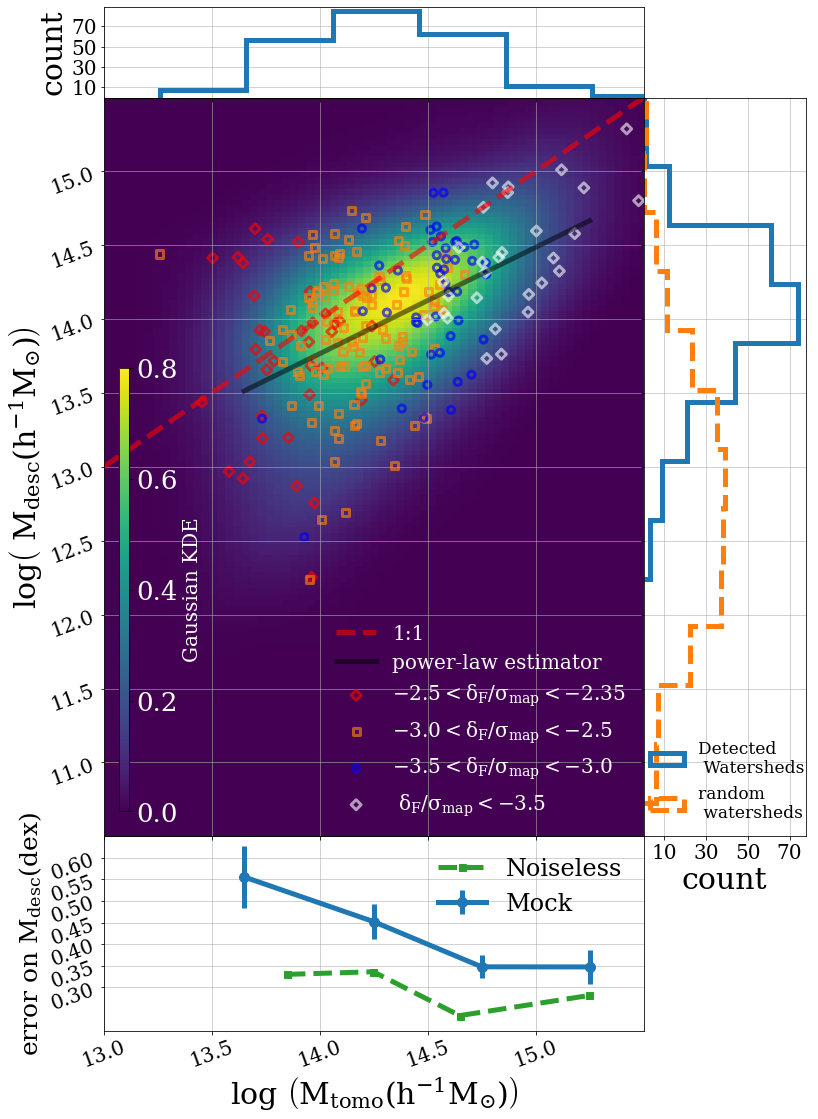

In [176]:
# definitions for the axes
left, width = 0.3, 0.5
bottom, height = 0.3, 0.57

rect_scatter = [left, bottom, width, height]
rect_err = [left, bottom - 0.15 ,width, 0.15]
rect_histx = [left, bottom + height, width, 0.07]
rect_histy = [left + width , bottom, 0.15, height]

# start with a square Figure
fig_mock = plt.figure(figsize=(15, 18))
#fig_rand, ax_rand = plt.subplots(1,1,figsize=(10,10))

ax_err_mock = fig_mock.add_axes(rect_err)
ax = fig_mock.add_axes(rect_scatter, sharex=ax_err_mock)
ax_histx = fig_mock.add_axes(rect_histx, sharex=ax)
ax_histy = fig_mock.add_axes(rect_histy, sharey=ax)

scatter_hist(n=1, fig=fig_mock, ax=ax, ax_histx=ax_histx, ax_histy=ax_histy,
             ax_err = ax_err_mock, ax_err_label='Mock', offset=0.114,
             conversion_not_adjusted=False, plot_kde=True, z=2.4, sigma='4')
plt.tight_layout()
fig_mock.savefig('./figures/M0_Mtomo_scatter_sigma4.pdf', transparent=False)

## z=2.4 and $\sigma = 2$:

Number of watersheds =  639
Slope :  1.110+-0.065
The prefactor :  13.94+-0.027


<ipython-input-177-fcc19ef287fe>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


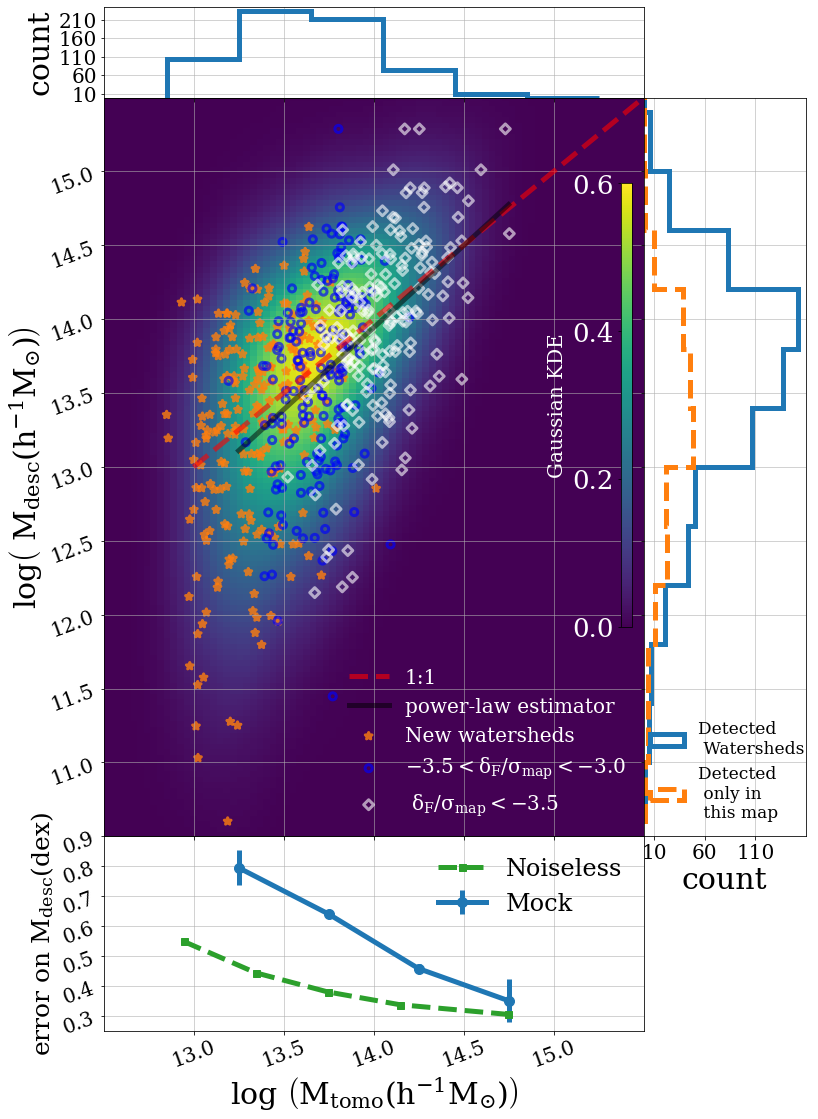

In [177]:
# definitions for the axes
left, width = 0.3, 0.5
bottom, height = 0.3, 0.57

rect_scatter = [left, bottom, width, height]
rect_err = [left, bottom - 0.15 ,width, 0.15]
rect_histx = [left, bottom + height, width, 0.07]
rect_histy = [left + width , bottom, 0.15, height]

# start with a square Figure
fig_mock = plt.figure(figsize=(15, 18))
#fig_rand, ax_rand = plt.subplots(1,1,figsize=(10,10))

ax_err_mock = fig_mock.add_axes(rect_err)
ax = fig_mock.add_axes(rect_scatter, sharex=ax_err_mock)
ax_histx = fig_mock.add_axes(rect_histx, sharex=ax)
ax_histy = fig_mock.add_axes(rect_histy, sharey=ax)

scatter_hist(n=1, fig=fig_mock, ax=ax, ax_histx=ax_histx, ax_histy=ax_histy,
             ax_err = ax_err_mock, ax_err_label='Mock', offset=0.114,
             conversion_not_adjusted=False, plot_kde=True, z=2.4, sigma='2',
             th='2.75', lc='2.30', bins_err=np.array([13,13.5,14,14.5,15]))
plt.tight_layout()
fig_mock.savefig('./figures/M0_Mtomo_scatter_sigma2.pdf')

In [196]:
def get_mean_err_sigma2_sigma4(nmocks=20,  co_sig2=[0.72, 13.8], co_sig4=(1.11,13.9)):
    
    bins = np.array([13,13.5,14,14.5,15,15.5,16])
    mbins = np.array([(bins[b]+bins[b+1])/2 for b in range(bins.size-1)])
    dev_bins_all = [np.empty((nmocks, mbins.size)), np.empty((nmocks, mbins.size))]
    print(dev_bins_all[0].shape)
    
    for i, n in enumerate(np.arange(1, nmocks+1)):
        fdesc2, peaks2 = read_files(n=n, z=2.4, sigma='2', th='2.75', lc='2.30')
        fdesc4, peaks4 = read_files(n=n, z=2.4, sigma='4', th='2.35', lc='2.00')
        ind2 = fdesc2['peak_id'][:].astype(int)-1
        ind4 = fdesc4['peak_id'][:].astype(int)-1
        Mtomo = [peaks2['mtomo'][:][ind2], peaks4['mtomo'][:][ind4]] 
        GroupMass = [10+np.log10(fdesc2['GroupMass'][:]), 
                     10+np.log10(fdesc4['GroupMass'][:])]
        Mdesc_est = lambda x, p : (x-14)*p[0] +p[1]
        GroupMassFit = [ Mdesc_est(Mtomo[0], co_sig2),
                        Mdesc_est(Mtomo[1], co_sig4)]
        
        for j in range(2):
            dev = GroupMass[j] - GroupMassFit[j]
            for b in range(bins.size-1):
                indp = np.where((GroupMassFit[j]<bins[b+1])
                                *(GroupMassFit[j] > bins[b]))[0].astype(int)
                dev_bins = np.sqrt(np.dot(dev[indp],dev[indp])
                                   /indp.size)
                #print(j,i,b)
                dev_bins_all[j][i,b] =  dev_bins
            
    return np.median(dev_bins_all[0], axis=0), np.median(dev_bins_all[1], axis=0), \
np.std(dev_bins_all[0], axis=0), np.std(dev_bins_all[1], axis=0), mbins, bins
    
def plot_uncertainty_M0_paper_sigma(ax):
    plt.style.use('Notebook.mystyle')
    plt.rc('font', family='Serif')
    sigma = [2, 4]
    color = ['C1','C2']
    ls = [('solid','dotted'), ('dashed', '-.')]
    
    
    dev_bins2, dev_bins4, std2, std4, mbins, bins = get_mean_err_sigma2_sigma4()
    ind = np.where(dev_bins2 != np.nan)
    ax.errorbar(mbins[ind], dev_bins2[ind], yerr=std2[ind], marker='o', label='$\sigma = 2$',
                ls='solid', alpha=0.7, capsize=8, capthick=3)
    ind = np.where(dev_bins4 != np.nan)
    ax.errorbar(mbins[ind], dev_bins4[ind], yerr=std4[ind], marker='o', label='$\sigma = 4$',
                ls='dotted', alpha=0.7, capsize=8, capthick=3)
    ax.set_xlabel(r'$\mathrm{log[\ M_{desc}^{est} (h^{-1} M_{\odot})] }$', fontsize=30)
    ax.set_ylabel('RMS error on '+r'$\mathrm{M_{desc} \ (dex)}$', fontsize=34)
    ax.legend(fontsize=30, frameon=False)
    ax.set_xlim(13,15)
    ax.set_ylim(0, 1)
    plt.setp(ax.get_xticklabels(), rotation=20, fontsize=30)
    plt.setp(ax.get_yticklabels(), fontsize=30)
    plt.grid(True)


In [191]:
get_mean_err_sigma2_sigma4()

(20, 6)


<ipython-input-190-5f601419ba3d>:25: RuntimeWarning: invalid value encountered in double_scalars
  dev_bins = np.sqrt(np.dot(dev[indp],dev[indp])


(array([0.73828346, 0.60308137, 0.60137744,        nan,        nan,
               nan]),
 array([0.66302085, 0.50693335, 0.44038572, 0.47114363, 0.49205018,
               nan]),
 array([0.03280915, 0.01812896, 0.08438867,        nan,        nan,
               nan]),
 array([0.08391067, 0.03828187, 0.04125264, 0.04189028, 0.09174541,
               nan]),
 array([13.25, 13.75, 14.25, 14.75, 15.25, 15.75]),
 array([13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ]))

(20, 6)


<ipython-input-190-5f601419ba3d>:25: RuntimeWarning: invalid value encountered in double_scalars
  dev_bins = np.sqrt(np.dot(dev[indp],dev[indp])


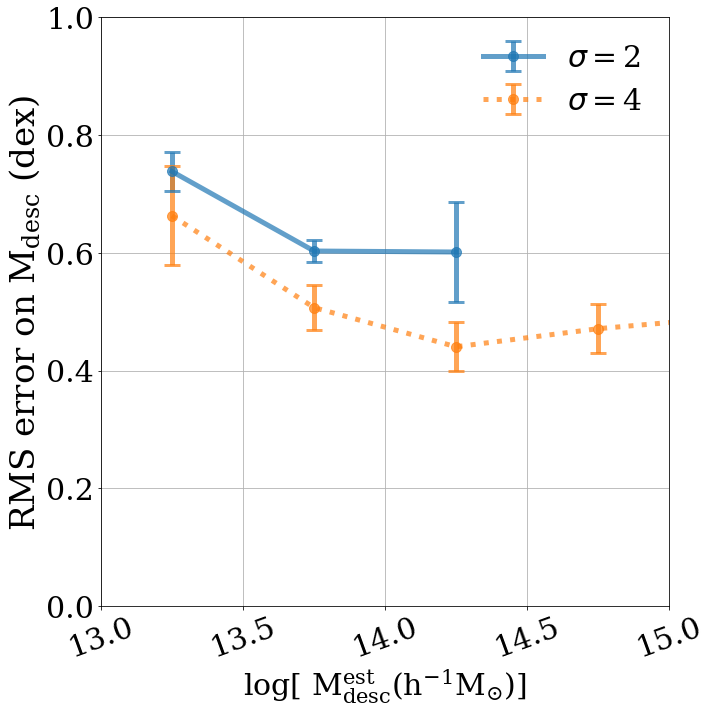

In [192]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
plot_uncertainty_M0_paper_sigma(ax)
plt.tight_layout()
plt.savefig('./figures/M0_Mtomo_sigma_err_M0fit.pdf',transparent=True)

## z=2.3:

if we use $\delta_F$-vs-$\rho_{DM}$ for that particular redshift.

Number of watersheds =  189
Number of watersheds =  189
Slope :  0.759+-0.092
The prefactor :  13.74+-0.051


<ipython-input-183-36fd3a7baae0>:87: RuntimeWarning: invalid value encountered in double_scalars
  err.append(np.sqrt(np.sum(dev*dev)/dev.size))
<ipython-input-199-98b2e633e89f>:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


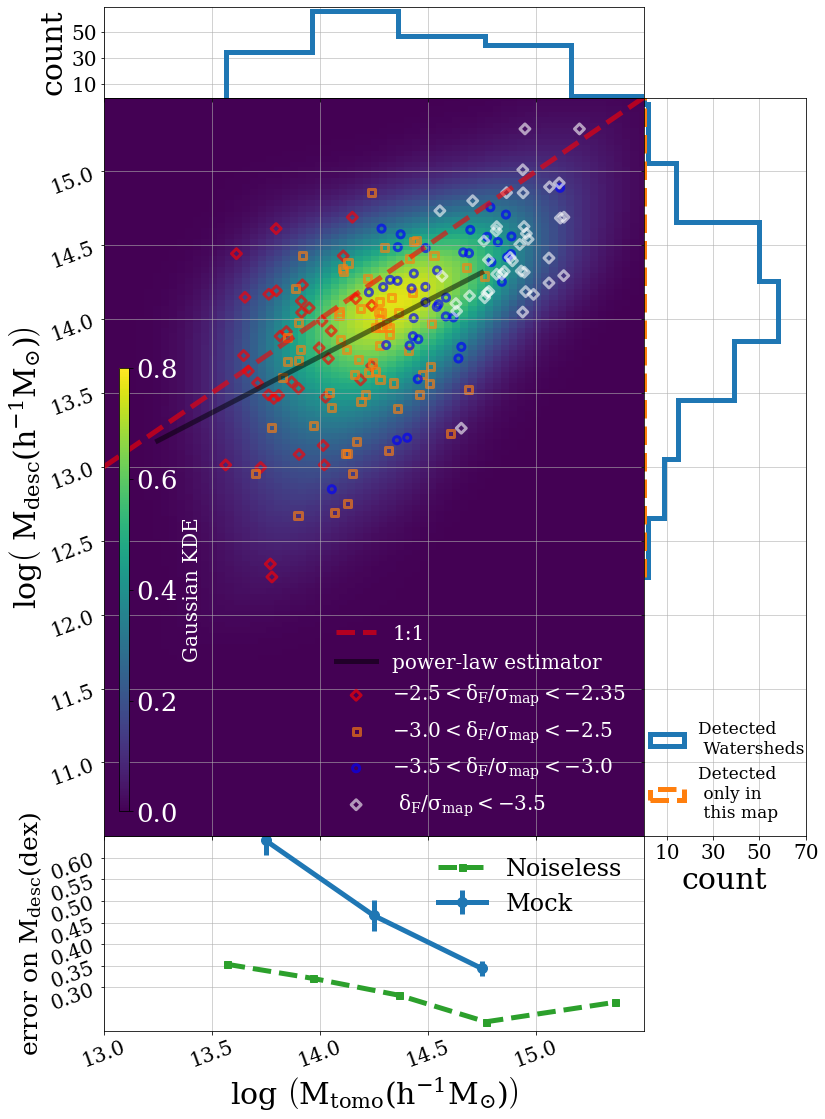

In [199]:
# definitions for the axes
left, width = 0.3, 0.5
bottom, height = 0.3, 0.57

rect_scatter = [left, bottom, width, height]
rect_err = [left, bottom - 0.15 ,width, 0.15]
rect_histx = [left, bottom + height, width, 0.07]
rect_histy = [left + width , bottom, 0.15, height]

# start with a square Figure
fig_mock = plt.figure(figsize=(15, 18))
#fig_rand, ax_rand = plt.subplots(1,1,figsize=(10,10))

ax_err_mock = fig_mock.add_axes(rect_err)
ax = fig_mock.add_axes(rect_scatter, sharex=ax_err_mock)
ax_histx = fig_mock.add_axes(rect_histx, sharex=ax)
ax_histy = fig_mock.add_axes(rect_histy, sharey=ax)

scatter_hist(n=1, fig=fig_mock, ax=ax, ax_histx=ax_histx, ax_histy=ax_histy,
             ax_err = ax_err_mock, ax_err_label='Mock', offset=0.114,
             conversion_not_adjusted=False, plot_kde=True, z=2.3, sigma='4',
             th='2.35', lc='2.00', bins_err=np.array([13,13.5,14,14.5,15]))
plt.tight_layout()
#fig_mock.savefig('M0_Mtomo_scatter_sigma4.pdf', transparent=True)

if we use $\delta_F$-vs-$\rho_{DM}$ for z=2.4

Number of watersheds =  189
Number of watersheds =  189
Slope :  0.761+-0.093
The prefactor :  13.76+-0.049


<ipython-input-183-36fd3a7baae0>:87: RuntimeWarning: invalid value encountered in double_scalars
  err.append(np.sqrt(np.sum(dev*dev)/dev.size))
<ipython-input-200-4a0ca2623e74>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-200-4a0ca2623e74>:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


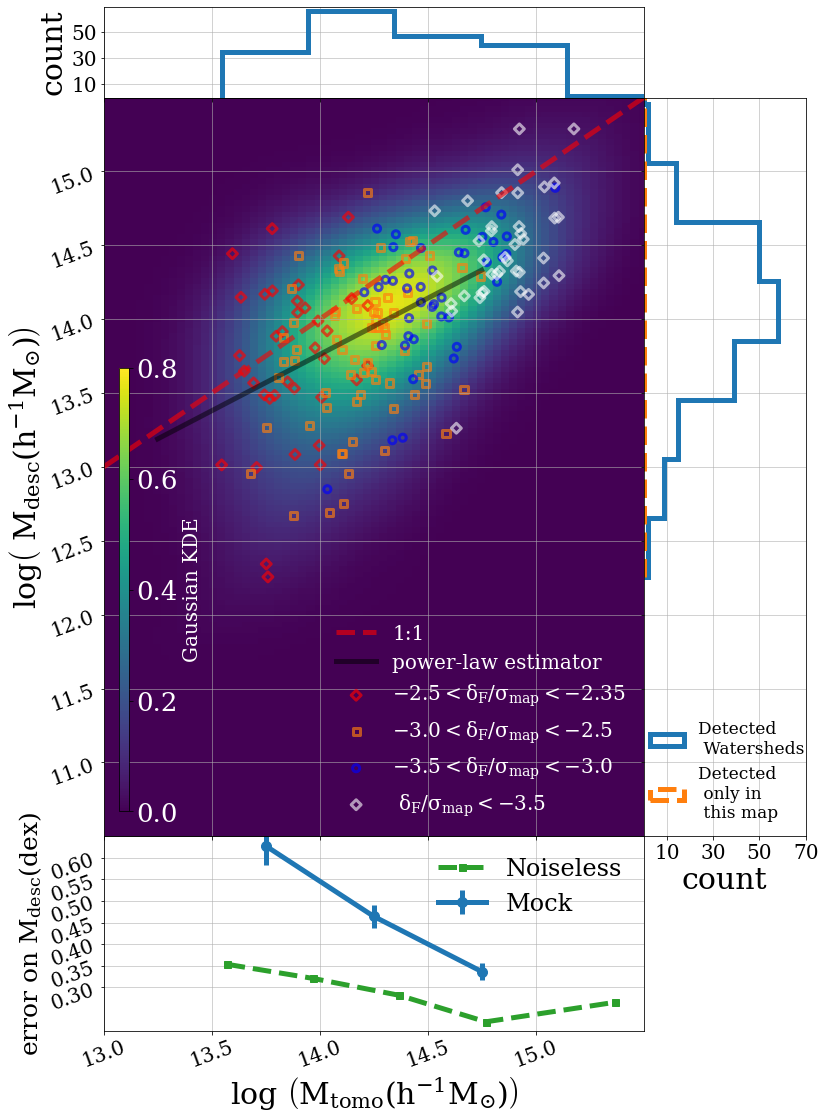

In [200]:
# definitions for the axes
left, width = 0.3, 0.5
bottom, height = 0.3, 0.57

rect_scatter = [left, bottom, width, height]
rect_err = [left, bottom - 0.15 ,width, 0.15]
rect_histx = [left, bottom + height, width, 0.07]
rect_histy = [left + width , bottom, 0.15, height]

# start with a square Figure
fig_mock = plt.figure(figsize=(15, 18))
#fig_rand, ax_rand = plt.subplots(1,1,figsize=(10,10))

ax_err_mock = fig_mock.add_axes(rect_err)
ax = fig_mock.add_axes(rect_scatter, sharex=ax_err_mock)
ax_histx = fig_mock.add_axes(rect_histx, sharex=ax)
ax_histy = fig_mock.add_axes(rect_histy, sharey=ax)

scatter_hist(n=1, fig=fig_mock, ax=ax, ax_histx=ax_histx, ax_histy=ax_histy,
             ax_err = ax_err_mock, ax_err_label='Mock', offset=0.114,
             conversion_not_adjusted=True, plot_kde=True, z=2.3, sigma='4',
             th='2.35', lc='2.00', bins_err=np.array([13,13.5,14,14.5,15]))
plt.tight_layout()
plt.tight_layout()
#fig_mock.savefig('M0_Mtomo_scatter_sigma4.pdf', transparent=True)

## z=2.6:

if we use $\delta_F$-vs-$\rho_{DM}$ for that particular redshift.

Number of watersheds =  212
Number of watersheds =  212
Slope :  0.769+-0.085
The prefactor :  13.76+-0.041


<ipython-input-203-0db77fb3b5d3>:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


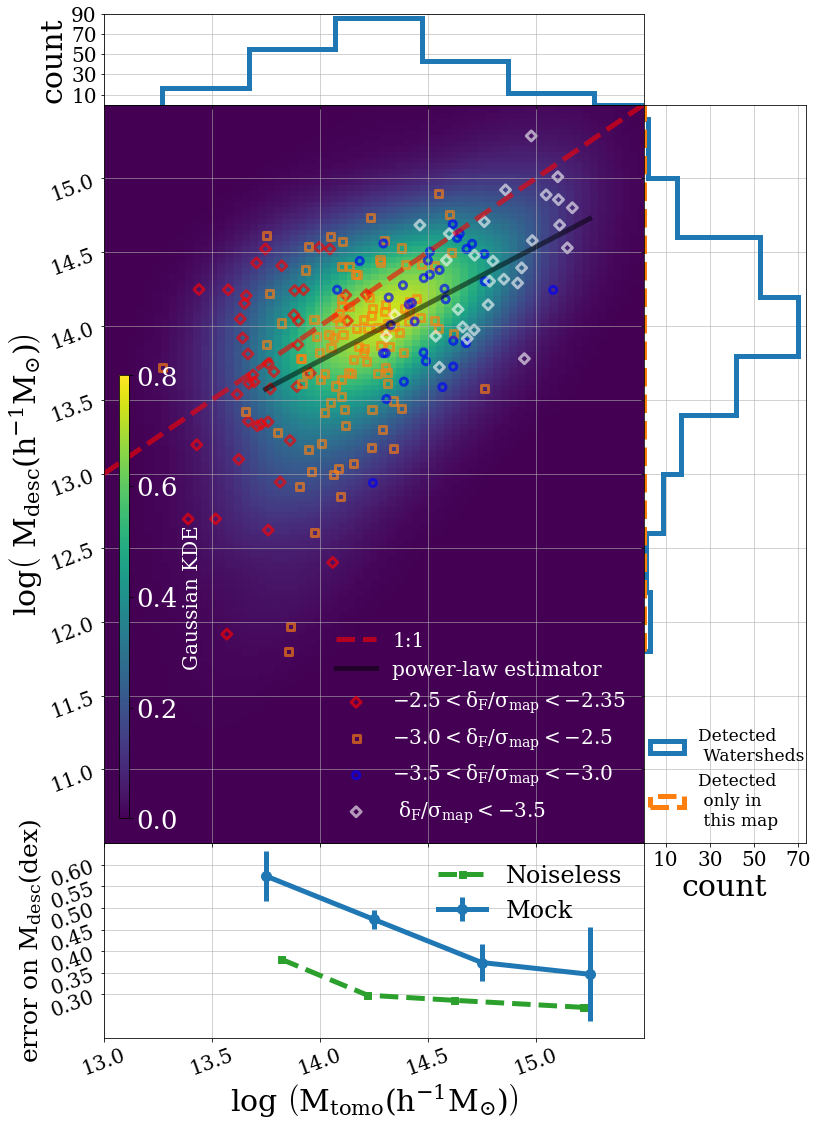

In [203]:
# definitions for the axes
left, width = 0.3, 0.5
bottom, height = 0.3, 0.57

rect_scatter = [left, bottom, width, height]
rect_err = [left, bottom - 0.15 ,width, 0.15]
rect_histx = [left, bottom + height, width, 0.07]
rect_histy = [left + width , bottom, 0.15, height]

# start with a square Figure
fig_mock = plt.figure(figsize=(15, 18))
#fig_rand, ax_rand = plt.subplots(1,1,figsize=(10,10))

ax_err_mock = fig_mock.add_axes(rect_err)
ax = fig_mock.add_axes(rect_scatter, sharex=ax_err_mock)
ax_histx = fig_mock.add_axes(rect_histx, sharex=ax)
ax_histy = fig_mock.add_axes(rect_histy, sharey=ax)

scatter_hist(n=1, fig=fig_mock, ax=ax, ax_histx=ax_histx, ax_histy=ax_histy,
             ax_err = ax_err_mock, ax_err_label='Mock', offset=0.114,
             conversion_not_adjusted=False, plot_kde=True, z=2.6, sigma='4',
             th='2.35', lc='2.00', bins_err=np.array([13.5,14,14.5,15, 15.5]))

plt.tight_layout()
#fig_mock.savefig('M0_Mtomo_scatter_sigma4.pdf', transparent=True)

if we use $\delta_F$-vs-$\rho_{DM}$ at z=2.45 :

Number of watersheds =  212
Number of watersheds =  212
Slope :  0.768+-0.084
The prefactor :  13.76+-0.042


<ipython-input-204-929402f90686>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


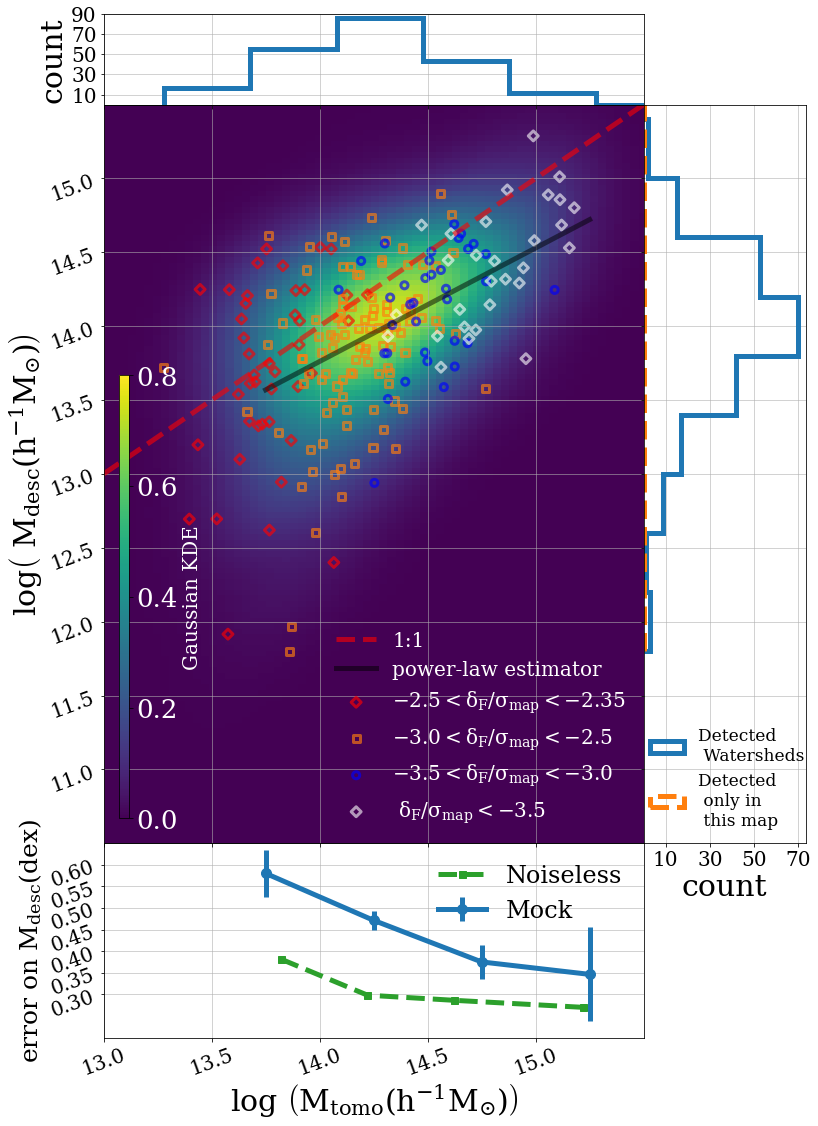

In [204]:
# definitions for the axes
left, width = 0.3, 0.5
bottom, height = 0.3, 0.57

rect_scatter = [left, bottom, width, height]
rect_err = [left, bottom - 0.15 ,width, 0.15]
rect_histx = [left, bottom + height, width, 0.07]
rect_histy = [left + width , bottom, 0.15, height]

# start with a square Figure
fig_mock = plt.figure(figsize=(15, 18))
#fig_rand, ax_rand = plt.subplots(1,1,figsize=(10,10))

ax_err_mock = fig_mock.add_axes(rect_err)
ax = fig_mock.add_axes(rect_scatter, sharex=ax_err_mock)
ax_histx = fig_mock.add_axes(rect_histx, sharex=ax)
ax_histy = fig_mock.add_axes(rect_histy, sharey=ax)

scatter_hist(n=1, fig=fig_mock, ax=ax, ax_histx=ax_histx, ax_histy=ax_histy,
             ax_err = ax_err_mock, ax_err_label='Mock', offset=0.114,
             conversion_not_adjusted=True, plot_kde=True, z=2.6, sigma='4',
             th='2.35', lc='2.00', bins_err=np.array([13.5,14,14.5,15, 15.5]))
plt.tight_layout()
#fig_mock.savefig('M0_Mtomo_scatter_sigma4.pdf', transparent=True)

Summarizing the redshift differences :

1. Errors in the mass bins are the same.

2. The slopes and intercepts match within the uncertainties. 

|z | # Watersheds | slope | intercept |
|--|--|--| --|
|2.3| --  | 0.76 +-0.09 | 13.74+-0.06|
|2.4| -- | 0.72+-0.09 | 13.76+-0.05|
|2.6| -- | 0.77+-0.09 | 13.76+-0.05|

3. It does not matter whether we use $\delta_F$-vs-$\rho_{DM}$ relation at the midpoint redshift or adjust it for each redshift bin.


So, we conclude if we use same watershed parameters (i.e. $\kappa$  and $\nu$ ) and same $\delta_F$-vs-$\rho_{DM}$ estimator for the full observed LATIS map, the estimators provided for the DM mass within the watersheds (studies in [this notebook](https://github.com/mahdiqezlou/LyTomo-Watershed/blob/main/MDM_Mtomo.ipynb)) and $M_{desc}$ are not chaning with redshift. This makes life much easier when applying to the observed map!